In [1]:


import scanpy as sc
import decoupler as dc
import anndata as ad

# Only needed for processing
import numpy as np
import pandas as pd

# Needed for some plotting
import matplotlib.pyplot as plt

# Import DESeq2
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats

# Plotting options, change to your liking
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))



## Human Systemic Lupus Erythematosus

In [17]:
# Load raw counts
data = pd.read_csv('../../data/SLE/GSE110999_raw_counts_GRCh38.p13_NCBI.tsv', sep='\t', index_col=0)

,GSM3019881,GSM3019882,GSM3019883,GSM3019884,GSM3019885,GSM3019886,GSM3019887,GSM3019888,GSM3019889,GSM3019890,...,GSM3019919,GSM3019920,GSM3019921,GSM3019922,GSM3019923,GSM3019924,GSM3019925,GSM3019926,GSM3019927,GSM3019928
GeneID,,,,,,,,,,,,,,,,,,,,,
100287102,9,11,15,12,7,6,8,8,6,7,...,89,48,48,7,54,121,53,34,38,108
653635,2625,2607,3592,3095,1491,1649,1916,1750,2504,2230,...,87,42,70,23,51,114,74,66,45,112
102466751,52,47,85,60,46,54,57,34,86,81,...,5,3,2,1,2,3,1,3,1,5
107985730,0,1,0,0,1,0,1,1,0,0,...,72,42,37,8,43,51,34,25,25,56
100302278,1,0,0,0,0,0,0,0,0,0,...,15,9,15,0,13,15,9,4,5,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4541,42755,54745,52320,35788,69678,116192,109529,92913,126024,134699,...,11494,2181,12772,5253,12971,23098,6288,2563,32,7161
4556,3197,3962,3713,2506,5280,8462,7623,6891,9739,9880,...,2209,394,2360,907,2548,4378,1186,434,6,1356
4519,47988,62818,90453,48160,113319,184066,197301,185516,198208,191482,...,30580,5560,34124,14561,36599,60310,15865,6509,115,17891


In [18]:
# Load gene annotation and replace GeneIDs with gene symbols
annot = pd.read_csv('../../data/SLE/Human.GRCh38.p13.annot.tsv', sep='\t')
data.index = annot['Symbol']

/tmp/ipykernel_4402/1102602081.py:2: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  annot = pd.read_csv('../../data/SLE/Human.GRCh38.p13.annot.tsv', sep='\t')


In [20]:
# Transform to AnnData object
adata = ad.AnnData(data.T, dtype=np.float32)
adata.var_names_make_unique()
adata

/home/lorna/miniconda3/envs/gretabench/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 46 × 39376

In [10]:
# Load metadata
meta = pd.read_csv('../../data/SLE/metadata.txt', sep='\t', index_col=0)
adata.obs = meta

In [11]:
SLE_adata = adata[adata.obs['group'].isin(['SLE'])].copy()

In [13]:
SLE_adata

AnnData object with n_obs × n_vars = 16 × 39376
    obs: 'group', 'subset'

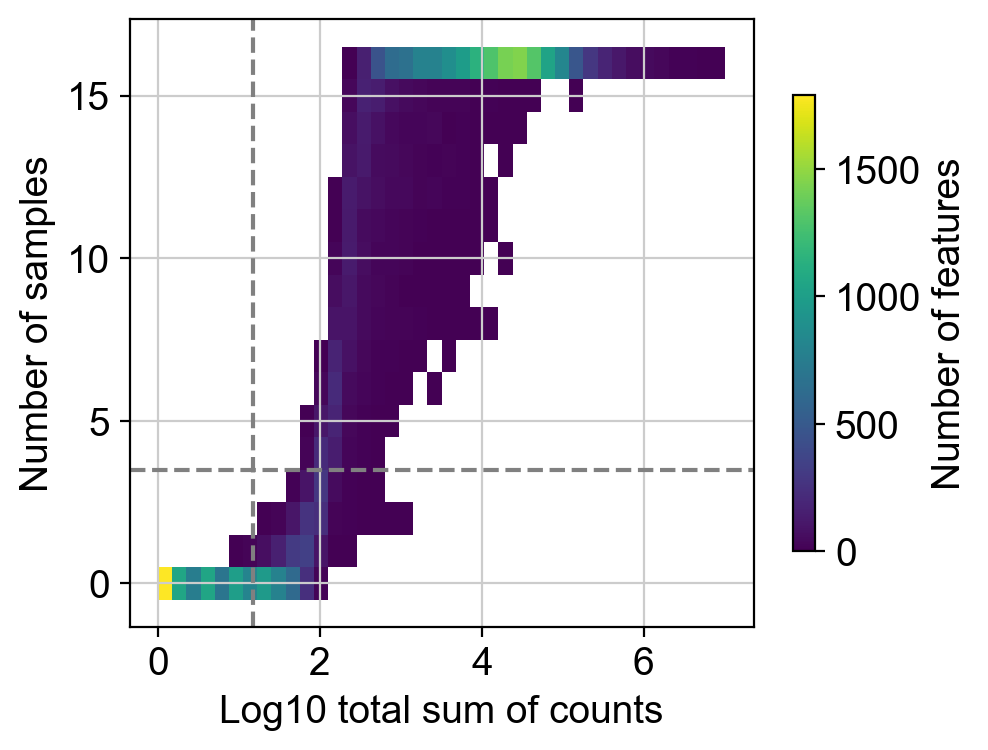

In [12]:
dc.plot_filter_by_expr(SLE_adata, group='subset', min_count=10, min_total_count=15, large_n=1, min_prop=1)

In [14]:
# Obtain genes that pass the thresholds
genes = dc.filter_by_expr(SLE_adata, group='subset', min_count=10, min_total_count=15, large_n=1, min_prop=1)

# Filter by these genes
SLE_adata = SLE_adata[:, genes].copy()
SLE_adata

AnnData object with n_obs × n_vars = 16 × 19388
    obs: 'group', 'subset'

In [15]:
SLE_adata.write('../../data/SLE/SLE_adata_prc.h5ad')

In [13]:
# Build DESeq2 object
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    adata=SLE_adata,
    design='~subset',
    refit_cooks=True,
    inference=inference,
)

In [14]:
# Compute LFCs
dds.deseq2()

Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.03 seconds.

Fitting dispersions...
... done in 13.03 seconds.

Fitting dispersion trend curve...
... done in 2.23 seconds.

Fitting MAP dispersions...
... done in 13.76 seconds.

Fitting LFCs...
... done in 5.83 seconds.

Calculating cook's distance...
... done in 0.05 seconds.

Replacing 0 outlier genes.



In [81]:
# Extract contrast between CD11chi_IgDpos vs memory_B cells
stat_res_mem = DeseqStats(
    dds,
    contrast=["subset", 'CD11chi_IgDpos', 'memory_B'],
    inference=inference
)

# Compute Wald test
stat_res_mem.summary()

# Extract results
results_mem = stat_res_mem.results_df

# Filter results
filtered_mem = results_mem[results_mem['log2FoldChange'].abs() > 2]
filtered_mem = filtered_mem[filtered_res['padj'] < 0.05]
filtered_mem = filtered_mem.sort_values('log2FoldChange')

CD11_a = filtered_mem.head(n=100).index
mem = filtered_mem.tail(n=100).index

In [ ]:
# Extract contrast between CD11chi_IgDpos vs memory_B cells
stat_res_mem = DeseqStats(
    dds,
    contrast=["subset", 'CD11chi_IgDpos', 'naive_B'],
    inference=inference
)

# Compute Wald test
stat_res_naive.summary()

# Extract results
results_naive = stat_res_naive.results_df

# Filter results
filtered_naive = results_naive[results_naive['log2FoldChange'].abs() > 2]
filtered_naive = filtered_naive[filtered_naive['padj'] < 0.05]
filtered_naive = filtered_naive.sort_values('log2FoldChange')

CD11_b = filtered_naive.head(n=100).index
naive = filtered_naive.tail(n=100).index

In [89]:
CD11 = list(set(CD11_a).union(set(CD11_b)))

In [ ]:
DEGs_SLE = CD11 + mem + naive

In [68]:
pd.Series(SLE_adata.var_names).to_csv('../../data/SLE/SLE_genes.txt', index=False, header=False)

## T Cell Exhaustion

In [62]:
S401 = pd.read_csv('../../data/Tcell_exhaustion/data/GSM3897743_R_OK_S401_RNA_counts.txt', sep='\t', index_col=0, header=None)
S402 = pd.read_csv('../../data/Tcell_exhaustion/data/GSM3897744_R_OK_S402_RNA_counts.txt', sep='\t', index_col=0, header=None)
S403 = pd.read_csv('../../data/Tcell_exhaustion/data/GSM3897745_R_OK_S403_RNA_counts.txt', sep='\t', index_col=0, header=None)
S404 = pd.read_csv('../../data/Tcell_exhaustion/data/GSM3897746_R_OK_S404_RNA_counts.txt', sep='\t', index_col=0, header=None)
S405 = pd.read_csv('../../data/Tcell_exhaustion/data/GSM3897747_R_OK_S405_RNA_counts.txt', sep='\t', index_col=0, header=None)
S406 = pd.read_csv('../../data/Tcell_exhaustion/data/GSM3897748_R_OK_S406_RNA_counts.txt', sep='\t', index_col=0, header=None)


In [63]:
# Reformatting input data
data = pd.concat([S401, S402, S403, S404, S405, S406], axis=1)
data.columns = ['S401', 'S402', 'S403', 'S404', 'S405', 'S406']
data.index.name = 'gene'

In [85]:
# Transform to AnnData object
adata = ad.AnnData(data.T, dtype=np.float32)
adata.var_names_make_unique()
adata

/home/lorna/miniconda3/envs/gretabench/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6 × 19675

In [72]:
meta = pd.read_csv('../../data/Tcell_exhaustion/metadata.txt', sep='\t', index_col=0)
adata.obs = meta

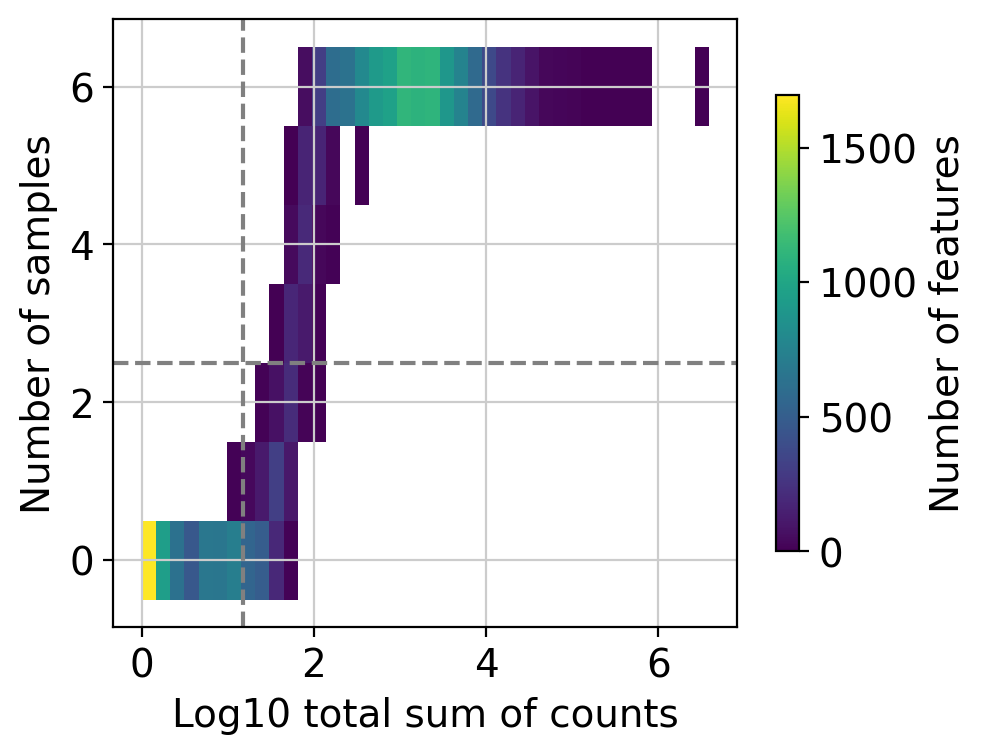

In [76]:
dc.plot_filter_by_expr(adata, group='group', min_count=10, min_total_count=15, large_n=1, min_prop=1)

In [87]:
# Obtain genes that pass the thresholds
genes = dc.filter_by_expr(adata, group='group', min_count=10, min_total_count=15, large_n=1, min_prop=1)

# Filter by these genes
adata = adata[:, genes].copy()
adata

AnnData object with n_obs × n_vars = 6 × 11740
    obs: 'group'

In [88]:
adata.write('../../data/Tcell_exhaustion/adata_prc.h5ad')

In [4]:
# Build DESeq2 object
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    adata=adata,
    design='group',
    refit_cooks=True,
    inference=inference,
)

In [5]:
dds.deseq2()

Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.01 seconds.



Fitting dispersions...
... done in 7.55 seconds.

Fitting dispersion trend curve...
... done in 1.84 seconds.

Fitting MAP dispersions...
... done in 6.50 seconds.

Fitting LFCs...
... done in 3.07 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.



In [6]:
# Extract contrast between ko vs wt
stat_res = DeseqStats(
    dds,
    contrast=["group", 'ko', 'wt'],
    inference=inference
)

In [7]:
# Compute Wald test
stat_res.summary()

Running Wald tests...
... done in 2.00 seconds.



Log2 fold change & Wald test p-value: group ko vs wt
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene                                                                       
Gnai3          1731.982426        0.100040  0.068055  1.469985  0.141566   
Cdc45           122.531105       -0.673255  0.204322 -3.295070  0.000984   
Narf            301.119873        0.059882  0.129535  0.462281  0.643880   
Cav2              9.642843        0.643032  0.634714  1.013106  0.311009   
Klf6           3553.662858        0.321621  0.203318  1.581865  0.113680   
...                    ...             ...       ...       ...       ...   
RP23-7L11.5      78.218873       -0.002254  0.231561 -0.009736  0.992232   
RP24-344N22.4   145.465228        0.336973  0.197030  1.710263  0.087217   
Nup62           622.085148       -0.261706  0.096367 -2.715727  0.006613   
RP24-439I22.3    18.794268        0.321718  0.440640  0.730116  0.465320   
RP23-413C19.2    60.751182        0

In [8]:
results_df = stat_res.results_df
results_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene,,,,,,
Gnai3,1731.982426,0.100040,0.068055,1.469985,0.141566,0.413562
Cdc45,122.531105,-0.673255,0.204322,-3.295070,0.000984,0.013309
Narf,301.119873,0.059882,0.129535,0.462281,0.643880,0.854721
Cav2,9.642843,0.643032,0.634714,1.013106,0.311009,0.628226
Klf6,3553.662858,0.321621,0.203318,1.581865,0.113680,0.366248
...,...,...,...,...,...,...
RP23-7L11.5,78.218873,-0.002254,0.231561,-0.009736,0.992232,0.997324
RP24-344N22.4,145.465228,0.336973,0.197030,1.710263,0.087217,0.313129
Nup62,622.085148,-0.261706,0.096367,-2.715727,0.006613,0.056628


In [9]:
results_df.to_csv('../../data/Tcell_exhaustion/Deseq2_results_ko.tsv', sep='\t')

In [10]:
filtered_res = results_df[results_df['padj'] < 0.05]
filtered_res

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene,,,,,,
Cdc45,122.531105,-0.673255,0.204322,-3.295070,9.839707e-04,1.330854e-02
Scpep1,236.371669,-0.420221,0.138757,-3.028465,2.457995e-03,2.704486e-02
Itgb2,7911.954558,0.428782,0.065859,6.510591,7.485560e-11,7.447498e-09
Raf1,1391.219811,-0.228323,0.080197,-2.847022,4.413032e-03,4.168061e-02
Pdgfb,145.434587,0.512095,0.168498,3.039181,2.372225e-03,2.644817e-02
...,...,...,...,...,...,...
4930417O13Rik,87.675355,-0.672628,0.229256,-2.933957,3.346706e-03,3.387097e-02
RP23-361O12.4,136.984007,0.552113,0.179462,3.076487,2.094555e-03,2.395267e-02
RP24-178G20.2,124.831930,0.521425,0.187170,2.785841,5.338907e-03,4.810343e-02


In [95]:
pd.Series(filtered_res.index).to_csv('../../data/Tcell_exhaustion/DEGs_ko.txt', index=False, header=False)
pd.Series(results_df.index).to_csv('../../data/Tcell_exhaustion/genes.txt', index=False, header=False)